## Setup

In [1]:
import os
import pickle
import re

import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn.objects as so
import torch

from procyon.data.data_utils import DATA_DIR
from procyon.evaluate.framework.qa import calc_qa_metrics

[2025-03-26 12:50:49,037] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_name = "ProCyon"

llama_name = "Llama3-8B-HG"
llama_it_name = "Llama-HG"

mistral_name = "Mistral-HG"

gpt_aaseq_name = "GPT4-AA"
gpt_uniprot_name = "GPT4-UP"
gpt_hgnc_name = "GPT4-HG"

gpt_model_names =[
    gpt_aaseq_name,
    gpt_uniprot_name,
    gpt_hgnc_name
]

base_path = "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/"

In [3]:
uniprot_ids = pd.read_pickle(os.path.join(DATA_DIR, "integrated_data/v1/protein/", "protein_info_filtered.pkl"))[["index", "protein_id", "name"]]
prot_id_map = {row.protein_id: row.index for row in uniprot_ids.itertuples(index=False)}

In [4]:
def parse_dataset_string(s: str):
    aaseq, text, oth = s.split("_", maxsplit=2)
    if "eval" in oth:
        relation, split = [x.strip("_").rstrip("_") for x in oth.split("eval")]
        if split != "pt_ft" and split != "zero_shot" and split != "zero_shot_easy":
            split = "few_shot"
    else:
        relation = oth
        split = "all"
    return aaseq + "_" + text, relation, split


In [5]:
mol_func_name = "Function"
path_name = "Pathway"
dis_name = "Disease"

domain_order = [
    mol_func_name,
    path_name,
    dis_name,
]

kd_map = {
    "protein_uniprot_all": mol_func_name,
    "protein_reactome_all": path_name,
    "protein_disgenet_all": dis_name,

}

In [6]:
small_model = "Small (1X)"
med_model = "Medium (10X)"
frontier_model = "Frontier (>50X)"
model_classes = [
    small_model,
    med_model,
    frontier_model,
]

llm_models = [
    llama_name,
    llama_it_name,
    mistral_name,
] + gpt_model_names

llm_model_colors = {
    model: c for model, c in zip(llm_models, sns.color_palette("pastel"))
}
llm_model_colors[model_name] = "#9467BD"

In [7]:
plt.rcParams['svg.fonttype'] = 'none'

# Reference-based metrics

In [8]:
gpt_path = "/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/reference_based_metrics"
mistral_path = "/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/caption_eval/reference_based_metrics"
llama_path = "/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/reference_based_metrics/"

results = {
    llama_name: os.path.join(llama_path, "llama3_base", "caption_metrics_summary.tsv"),
    llama_it_name: os.path.join(llama_path, "llama3_instruct", "caption_metrics_summary.tsv"),
    mistral_name: os.path.join(mistral_path, "mistral_large", "caption_metrics_summary.tsv"),
    gpt_aaseq_name: os.path.join(gpt_path, "gpt4_aaseq", "caption_metrics_summary.tsv"),
    gpt_uniprot_name: os.path.join(gpt_path, "gpt4_uniprot", "caption_metrics_summary.tsv"),
    gpt_hgnc_name: os.path.join(gpt_path, "gpt4_gene_name", "caption_metrics_summary.tsv"),
    model_name: "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/caption_gpt_comparison/caption_metrics.tsv",
    #"TxPLM-multiple": "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/caption_gpt_comparison_multiple/caption_metrics.tsv",

}

In [9]:
all_metrics = []
for model_name, path in results.items():
    metrics = (
        pd.read_table(path)
        .assign(
            model=model_name
        )
    )
    if model_name == "TxPLM":
        metrics = (
            metrics
            .assign(
                dataset=lambda x: x.dataset.str.replace("_all", "", 1),
            )
            .loc[lambda x: ~x.dataset.str.contains("drugbank")]
        )
    all_metrics.append(metrics)

all_metrics = (
    pd.concat(all_metrics)
    .loc[:, lambda x: ~x.columns.to_series().str.endswith("_mean")]
    .assign(
        dataset=lambda x: x.dataset.str.replace("_all_all", "_all"),
    )
    .loc[lambda x: x.dataset.isin(kd_map)]
    .drop(columns=["seq_id"])
)

all_metrics.head()

,bertscore_precision_max,bertscore_recall_max,bertscore_f1_max,rouge1_max,rouge2_max,rougeL_max,bleu1_max,bleu2_max,bleu3_max,bleu4_max,dataset,model
0,-0.288621,-0.067824,-0.202195,0.110623,0.016726,0.100039,0.090987,0.014352,0.005907,0.003465,protein_disgenet_all,Llama3-8B-HG
1,-0.124837,-0.149525,-0.160402,0.145156,0.019146,0.091334,0.303668,0.055851,0.012699,0.005588,protein_reactome_all,Llama3-8B-HG
2,-0.231201,0.071869,-0.109319,0.091118,0.024306,0.073116,0.071170,0.018014,0.009257,0.006033,protein_uniprot_all,Llama3-8B-HG
0,-0.464273,-0.030505,-0.321670,0.094582,0.012171,0.073038,0.050596,0.007185,0.002353,0.001257,protein_disgenet_all,Llama-HG
1,-0.055091,-0.063207,-0.076692,0.232118,0.033686,0.140115,0.416528,0.077513,0.012735,0.004465,protein_reactome_all,Llama-HG


### QA Filtering

In [10]:
base_path = "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/caption_gpt_comparison_multiple/caption/TxPLM"

dataset_paths = [f for f in os.listdir(base_path) if not "drugbank" in f]
dataset_paths

['protein_reactome_all_all',
 'protein_disgenet_all_all',
 'protein_uniprot_all_all']

In [11]:
from typing import Callable
from scipy.stats import bootstrap

from procyon.evaluate.framework.caption import summarize_metrics

metric_cols = [
    'bertscore_precision',
    'bertscore_recall',
    'bertscore_f1',
    'rouge1',
    'rouge2',
    'rougeL',
    'bleu1',
    'bleu2',
    'bleu3',
    'bleu4',
]




# def filter_captions(dataset, thresh=0.6, min_keep=0):
#     """QA filter captions"""
#     filtered = []
#     for _, df in dataset.groupby("seq_id"):
#         df = df.sort_values("yes", ascending=False)
#         above_thresh = df.yes >= thresh
#         if above_thresh.sum() < min_keep:
#             filtered.append(df.head(n=min_keep))
#         else:
#             filtered.append(df.loc[above_thresh])
#     return pd.concat(filtered).reset_index()


# def unfilt_metrics(dataset, thresh=0.6, min_keep=0):
#     captions = get_scored_captions(dataset)

#     unfilt_summary = metrics_to_summary(captions, dataset)

#     num_seqs_before = len(captions.seq_id.unique())
#     num_captions_before = len(captions.drop_duplicates(["seq_id", "generated_caption"]))
#     filt = filter_captions(captions, thresh, min_keep)
#     num_seqs_after = len(filt.seq_id.unique())
#     num_captions_after = len(filt.drop_duplicates(["seq_id", "generated_caption"]))

#     print(
#         f"filtering on p(yes)={thresh}: num proteins: {num_seqs_before} -> {num_seqs_after} , "
#         f"num captions: {num_captions_before} -> {num_captions_after} , "
#     )
#     filt_summary = metrics_to_summary(filt, dataset)

#     return unfilt_summary, filt_summary




# def qa_filt_metrics_full_summary(dataset, metric="bertscore_f1"):
#     captions = get_scored_captions(dataset)
#     raw = (
#         captions
#         # For each (protein, generated caption) pair, get the max of the metric
#         # across reference captions
#          .groupby(["seq_id", "generated_caption"])
#          [[metric, "yes"]]
#          .max()
#         .reset_index()
#         # For each protein, take the metric value coming from the generated
#         # caption with the highest p(yes)
#         .sort_values("yes", ascending=False)
#         .groupby("seq_id")
#         .head(n=1)
#         # Average across proteins.
#         [metric]
#     )
#     metric_summary = raw.describe().to_dict()
#     metric_summary["dataset"] = dataset
#     return metric_summary, raw

# def metrics_to_summary(df, dataset):
#     """Summarize caption metrics per protein query, generating mean and max of each metric."""
#     return (
#         df
#         [["seq_id"] + metric_cols]
#         .groupby("seq_id")
#         .apply(lambda x: summarize_metrics(x, metric_cols))
#         .reset_index()
#         .drop(columns="seq_id").mean()
#         .to_frame()
#         .T
#         .assign(dataset=dataset)
#     )

def get_scored_captions(dataset):
    """Get captions with QA filtering score"""
    dataset_dir = os.path.join(base_path, dataset)
    filt_path = [f for f in os.listdir(dataset_dir) if f.endswith(".csv")][0]
    with open(os.path.join(dataset_dir, "full_captions.tsv.gz"), "rb") as fh:
        full = pd.read_table(fh, compression="gzip")
    with open(os.path.join(dataset_dir, filt_path)) as fh:
        filt = pd.read_csv(fh)

    filt = (
        full
        .rename_axis(index="ref_index")
        .reset_index()
        .merge(filt[["ref_index", "yes", "no"]], on="ref_index")
    )
    return filt

def get_boostrap_vals(
    vals: np.array,
    num_bootstraps: int = 9999,
    ci: float = 0.95,
    batch_size: int = 10000,
    statistic: Callable = np.mean,
    seed: int = 42,
):
    rng = np.random.default_rng(seed=seed)

    inputs = (vals, )
    res = bootstrap(
        inputs,
        statistic=statistic,
        confidence_level=ci,
        n_resamples=num_bootstraps,
        batch=batch_size,
        random_state=rng,
        paired=False,
    )
    return res.confidence_interval.low, res.confidence_interval.high

def qa_filt_captions(dataset, metric="bertscore_f1"):
    captions = get_scored_captions(dataset)
    metric_val_per_seq = (
        captions
        # For each (protein, generated caption) pair, get the max of the metric
        # across reference captions
         .groupby(["seq_id", "generated_caption"])
         [[metric, "yes"]]
         .max()
        .reset_index()
        # For each protein, take the metric value coming from the generated
        # caption with the highest p(yes)
        .sort_values("yes", ascending=False)
        .groupby("seq_id")
        .head(n=1)
        # Average across proteins.
    )
    return metric_val_per_seq

def calc_metric_bounds(df, metric="bertscore_f1"):
    mean_val = df[metric].mean()
    lb, ub = get_boostrap_vals(df[metric].to_numpy())

    return {
        metric: mean_val,
        f"{metric}_lb": lb,
        f"{metric}_ub": ub,
    }

def qa_filt_metrics(dataset, metric="bertscore_f1"):
    metric_val_per_seq = qa_filt_captions(dataset)
    vals = calc_metric_bounds(metric_val_per_seq, metric)
    vals["dataset"] = dataset

    return vals

In [12]:
# Setting threshold to 1 just means taking the top caption per protein
# as measured by p("yes")
filtered_metrics = []
for p in dataset_paths:
    filtered_metrics.append(qa_filt_metrics(p))

filtered_metrics = (
    pd.DataFrame(filtered_metrics)
    .assign(
        model=model_name,
        dataset=lambda x: x.dataset.str.replace("_all", "", 1),
    )
    .rename(columns=lambda x: x.replace("bertscore_f1", "bertscore_f1_max"))
)

filtered_metrics

,bertscore_f1_max,bertscore_f1_max_lb,bertscore_f1_max_ub,dataset,model
0,0.199284,0.152211,0.253577,protein_reactome_all,ProCyon
1,0.162865,0.132950,0.202372,protein_disgenet_all,ProCyon
2,0.179789,0.141935,0.221600,protein_uniprot_all,ProCyon


In [13]:
all_filt_captions = []
for p in dataset_paths:
    all_filt_captions.append(qa_filt_captions(p).assign(dataset=p))
all_filt_captions =(
    pd.concat(all_filt_captions)
    .assign(
        dataset=lambda x: x.dataset.str.replace("_all", "", 1),
    )
)

filtered_metrics_agg = calc_metric_bounds(all_filt_captions)

filtered_metrics_agg = (
    pd.DataFrame(filtered_metrics_agg, index=[0])
    .assign(
        model=model_name,
    )
    .rename(columns=lambda x: x.replace("bertscore_f1", "bertscore_f1_max"))
)
all_filt_captions = (
    all_filt_captions
    .drop(columns=["seq_id", "yes", "generated_caption"])
    .assign(
        model=model_name,
    )
    .rename(columns=lambda x: x.replace("bertscore_f1", "bertscore_f1_max"))
)


filtered_metrics_agg

,bertscore_f1_max,bertscore_f1_max_lb,bertscore_f1_max_ub,model
0,0.179857,0.156295,0.203768,ProCyon


In [14]:
all_filt_captions

,bertscore_f1_max,dataset,model
579,0.960658,protein_reactome_all,ProCyon
123,0.960658,protein_reactome_all,ProCyon
462,0.170310,protein_reactome_all,ProCyon
457,0.170310,protein_reactome_all,ProCyon
502,0.016063,protein_reactome_all,ProCyon
...,...,...,...
593,0.191648,protein_uniprot_all,ProCyon
1131,0.148935,protein_uniprot_all,ProCyon
87,-0.413912,protein_uniprot_all,ProCyon
987,0.156589,protein_uniprot_all,ProCyon


### Load captioning metrics

In [15]:
def load_w_bootstrap(
    path: str,
    model: str,
    metric: str,
):
    df = []
    for fn in os.listdir(path):
        full_path = os.path.join(path, fn)
        if not os.path.isdir(full_path):
            continue
        metrics_path = os.path.join(path, fn, "caption_scores_per_seq.tsv.gz")
        metrics = pd.read_table(metrics_path, compression="gzip")
        lb, ub = get_boostrap_vals(metrics[metric].to_numpy())

        df.append({
            "model": model,
            "dataset": fn,
            metric: metrics[metric].mean(),
            f"{metric}_lb": lb,
            f"{metric}_ub": ub,
        })
    return pd.DataFrame(df)

def load_w_bootstrap_aggd(
    path: str,
    model: str,
    metric: str,
):
    all_filt_captions = []
    for fn in os.listdir(path):
        full_path = os.path.join(path, fn)
        if not os.path.isdir(full_path):
            continue
        metrics_path = os.path.join(path, fn, "caption_scores_per_seq.tsv.gz")
        metrics = pd.read_table(metrics_path, compression="gzip")
        all_filt_captions.append(metrics.assign(dataset=fn))
    all_filt_captions = pd.concat(all_filt_captions)

    filtered_metrics_agg = calc_metric_bounds(all_filt_captions, metric=metric)

    filtered_metrics_agg = (
        pd.DataFrame(filtered_metrics_agg, index=[0])
        .assign(
            model=model,
        )
    )
    return filtered_metrics_agg, all_filt_captions


want_metric = "bertscore_f1_max"
all_metrics = [filtered_metrics]
all_metrics_agg = [filtered_metrics_agg]
all_captions = [all_filt_captions]
for key, path in results.items():
    if key == model_name:
        continue

    all_metrics.append(load_w_bootstrap(os.path.dirname(path), key, want_metric))

    aggd_metrics, captions = load_w_bootstrap_aggd(os.path.dirname(path), key, want_metric)
    all_metrics_agg.append(aggd_metrics)
    all_captions.append(
        (
            captions
            .assign(model=key)
            [["model", "dataset", want_metric]]
        )
    )

all_metrics = (
    pd.concat(all_metrics)
    .loc[lambda x: ~x.dataset.str.contains("drugbank")]
    .assign(
        dataset=lambda x: x.dataset.str.replace("_all_all", "_all"),
    )
)
all_metrics_agg = pd.concat(all_metrics_agg)
all_captions = (
    pd.concat(all_captions)
    .assign(
        knowledge_domain=lambda x: x.dataset.map(kd_map)
    )
)
all_metrics

,bertscore_f1_max,bertscore_f1_max_lb,bertscore_f1_max_ub,dataset,model
0,0.199284,0.152211,0.253577,protein_reactome_all,ProCyon
1,0.162865,0.132950,0.202372,protein_disgenet_all,ProCyon
2,0.179789,0.141935,0.221600,protein_uniprot_all,ProCyon
0,-0.109319,-0.131241,-0.086997,protein_uniprot_all,Llama3-8B-HG
1,-0.202195,-0.216940,-0.185648,protein_disgenet_all,Llama3-8B-HG
2,-0.160402,-0.185328,-0.136842,protein_reactome_all,Llama3-8B-HG
0,-0.247870,-0.270341,-0.227035,protein_uniprot_all,Llama-HG
1,-0.321670,-0.343763,-0.301751,protein_disgenet_all,Llama-HG
2,-0.076692,-0.091461,-0.062414,protein_reactome_all,Llama-HG
0,0.038823,0.029003,0.049312,protein_disgenet_all,Mistral-HG


In [16]:
caption_plot_data = (
    all_metrics
    [["model", "bertscore_f1_max", "bertscore_f1_max_lb", "bertscore_f1_max_ub", "dataset"]]
    .assign(
        knowledge_domain=lambda x: x.dataset.map(kd_map),
        model_class=lambda x: np.where(x.model.str.contains("GPT4"),
                                       frontier_model,
                                       np.where(x.model.str.contains("Mistral"),
                                                med_model,
                                                small_model))
    )
)

caption_plot_data.head()

,model,bertscore_f1_max,bertscore_f1_max_lb,bertscore_f1_max_ub,dataset,knowledge_domain,model_class
0,ProCyon,0.199284,0.152211,0.253577,protein_reactome_all,Pathway,Small (1X)
1,ProCyon,0.162865,0.132950,0.202372,protein_disgenet_all,Disease,Small (1X)
2,ProCyon,0.179789,0.141935,0.221600,protein_uniprot_all,Function,Small (1X)
0,Llama3-8B-HG,-0.109319,-0.131241,-0.086997,protein_uniprot_all,Function,Small (1X)
1,Llama3-8B-HG,-0.202195,-0.216940,-0.185648,protein_disgenet_all,Disease,Small (1X)


Text(0.5, 1.0, 'model_class = Small (1X)')
Text(0.5, 1.0, 'model_class = Medium (10X)')
Text(0.5, 1.0, 'model_class = Frontier (>50X)')


Text(0.45, 0, 'LLM size class (parameter count relative to ProCyon)')

<Figure size 1000x1000 with 0 Axes>

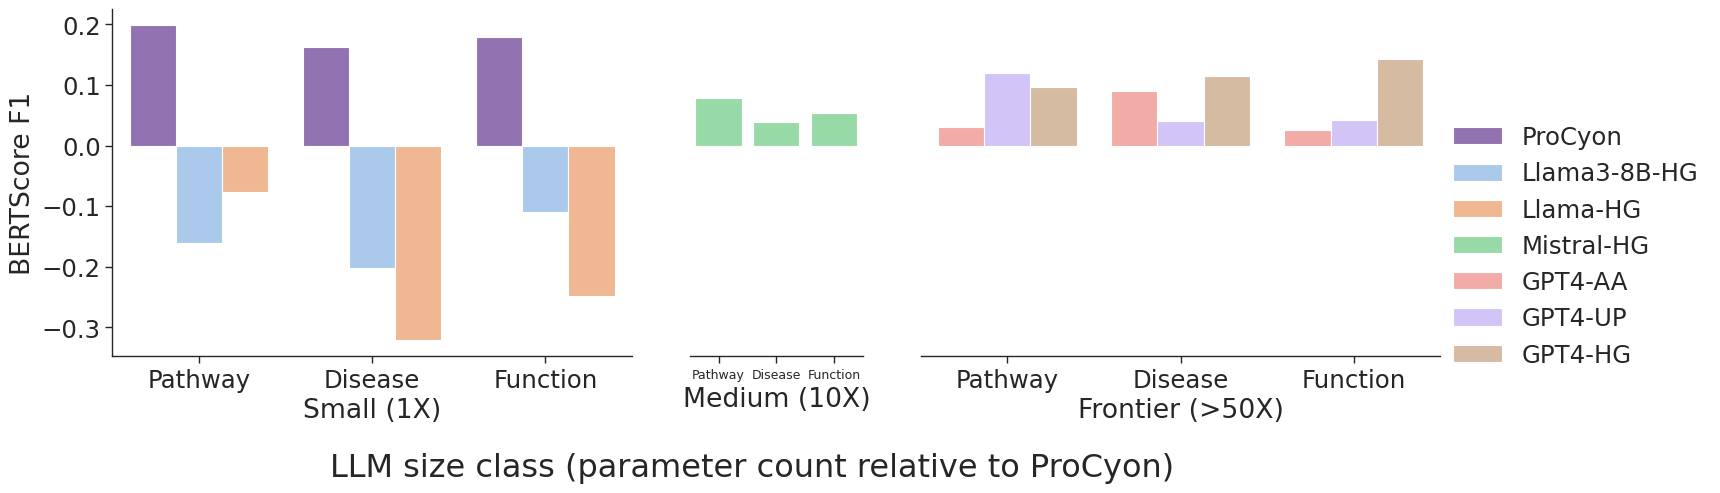

In [17]:
metric = "bertscore_f1_max"
models = llm_models + [model_name]
kd_order = ["Function", "Pathway", "Disease"]

sns.set_theme(context="paper", style="ticks", font_scale=2,)

plt.figure(figsize=(10, 10))

fg = sns.FacetGrid(
    col="model_class",
    col_order=model_classes,
    data=caption_plot_data,
    height=5,
    aspect=1,
    gridspec_kws={"width_ratios": [1, 1/3, 1]},
)
fg.map_dataframe(sns.barplot, x="knowledge_domain", y=metric, hue="model", palette=llm_model_colors)

sns.despine()
fg.add_legend()
fg.set_xlabels("")
fg.set_ylabels("BERTScore F1")
fg.despine()

for row in fg.axes:
    for i, ax in enumerate(row):
#        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        print(ax.title)
        curr_title = ax.title.get_text()
        model_class = curr_title.replace("model_class = ", "")
        ax.set_title("")
        ax.set_xlabel(model_class)
        if i != 0:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        if i == 1:
            ax.tick_params(axis='x', which='major', labelsize=9)
fg.figure.supxlabel(f"LLM size class (parameter count relative to {model_name})",y=0, va="top", x=0.45)


### Load QA metrics

In [18]:
txplm_dir = "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals"

subsampled_dir = "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/qa_eval/subsampled_outputs"
files = os.listdir(subsampled_dir)
files[:10]

['protein_ec_all_eval_pt_ft.qa.gene_name.gpt_prompts.responses.csv',
 'protein_go_component_eval_five_shot.qa.gene_name.gpt_prompts.responses.csv',
 'protein_disgenet_all_eval_zero_shot.qa.gene_name.gpt_prompts.responses.csv',
 'protein_go_function_eval_zero_shot.qa.gene_name.gpt_prompts.responses.csv',
 'protein_omim_all_eval_zero_shot_easy.qa.gene_name.gpt_prompts.responses.csv',
 'protein_go_function_eval_five_shot.qa.gene_name.gpt_prompts.responses.csv',
 'protein_disgenet_all_eval_zero_shot_easy.qa.gene_name.gpt_prompts.responses.csv',
 'protein_omim_all_eval_pt_ft.qa.gene_name.gpt_prompts.responses.csv',
 'protein_go_component_eval_zero_shot.qa.gene_name.gpt_prompts.responses.csv',
 'protein_go_process_eval_zero_shot.qa.gene_name.gpt_prompts.responses.csv']

In [19]:
all_subsampled_res = []
for fn in files:
    subsampled_out = (
        pd.read_csv(os.path.join(subsampled_dir, fn))
        .assign(
            seq_id=lambda x: x.protein_id.map(prot_id_map),
            rel_id=lambda x: x.seq_id.astype(str) + "_" + x["Text ID"].astype(str)
        )
    )

    dataset_name = fn.split(".")[0]
    if "zero_shot" in dataset_name:
        qa_dir = "qa_zero_shot"
    else:
        qa_dir = "qa"

    txplm_path = os.path.join(txplm_dir, qa_dir, "qa", "TxPLM", dataset_name, "results_dict.pkl")
    with open(txplm_path, "rb") as fh:
        txplm_out = (
            pd.DataFrame(pickle.load(fh))
            .assign(
                rel_id=lambda x: x.seq_id.astype(str) + "_" + x.text_id.astype(str)
            )
        )
    if not subsampled_out.rel_id.isin(txplm_out.rel_id).all():
        print(f"{dataset_name}: {subsampled_out.rel_id.isin(txplm_out.rel_id).value_counts()}")
        subset = txplm_out.head(n=128)
        print(f"{dataset_name}: {subsampled_out.rel_id.isin(subset.rel_id).value_counts()}")
    else:
        subset = txplm_out.loc[lambda x: x.rel_id.isin(subsampled_out.rel_id)]
    score_metrics = calc_qa_metrics(
        torch.tensor(subset.pred.to_list()),
        torch.tensor(subset.y.to_list()),
        4874,
        694,
    )
    score_metrics["dataset"] = dataset_name


    all_subsampled_res.append(score_metrics)
all_subsampled_res = pd.DataFrame(all_subsampled_res).assign(model=model_name)
all_subsampled_res.head()

protein_go_component_eval_five_shot: rel_id
True     65
False    63
Name: count, dtype: int64
protein_go_component_eval_five_shot: rel_id
True     64
False    64
Name: count, dtype: int64
protein_go_function_eval_five_shot: rel_id
True     68
False    60
Name: count, dtype: int64
protein_go_function_eval_five_shot: rel_id
True     64
False    64
Name: count, dtype: int64
protein_reactome_all_eval_pt_ft: rel_id
True     64
False    64
Name: count, dtype: int64
protein_reactome_all_eval_pt_ft: rel_id
True     64
False    64
Name: count, dtype: int64
protein_go_process_eval_five_shot: rel_id
True     66
False    62
Name: count, dtype: int64
protein_go_process_eval_five_shot: rel_id
True     64
False    64
Name: count, dtype: int64
protein_go_component_eval_pt_ft: rel_id
True     64
False    64
Name: count, dtype: int64
protein_go_component_eval_pt_ft: rel_id
True     64
False    64
Name: count, dtype: int64
protein_go_process_eval_pt_ft: rel_id
True     64
False    64
Name: count, dtype: 

,acc,acc_lb,acc_ub,f1,f1_lb,f1_ub,dataset,model
0,0.750000,0.671875,0.820312,0.746973,0.665255,0.819420,protein_ec_all_eval_pt_ft,ProCyon
1,0.687500,0.601562,0.765625,0.687424,0.608515,0.765568,protein_go_component_eval_five_shot,ProCyon
2,0.585938,0.500000,0.671875,0.569516,0.484893,0.657754,protein_disgenet_all_eval_zero_shot,ProCyon
3,0.728682,0.643411,0.798450,0.728617,0.650827,0.805453,protein_go_function_eval_zero_shot,ProCyon
4,0.781250,0.703125,0.851562,0.779907,0.701961,0.848897,protein_omim_all_eval_zero_shot_easy,ProCyon


In [20]:
gpt_extended_metrics = pd.read_table("/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/qa_eval/subsampled/parsed_results.tsv")
gpt_context_aug_metrics = pd.read_table("/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/qa_eval/with_context_aug/subsampled/parsed_results.tsv")
llama_metrics = pd.read_table("/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/llama_comparison/qa_eval/parsed_results.tsv")
mistral_metrics = (
    pd.read_table("/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/qa_eval/parsed_results.tsv")
    .assign(model=mistral_name)
)

eval_path = "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals"
txplm_extended_metrics = (
    pd.concat((
        pd.read_table(os.path.join(eval_path, "qa", "qa_metrics.tsv")),
        pd.read_table(os.path.join(eval_path, "qa_zero_shot", "qa_metrics.tsv")),
    ))
    .loc[lambda x: x.dataset.str.contains("eval")]
)


In [21]:
qa_metrics = (pd.read_table("~/gpt4_qa_comparison_metrics.tsv")
              .loc[lambda x: x.model.str.contains("GPT4")])

print(len(qa_metrics))
qa_metrics = (
    qa_metrics
    .assign(tmp_id=lambda x: x.model + "_" + x.dataset)
    .loc[lambda x: ~x.tmp_id.isin(gpt_context_aug_metrics.model + "_" + gpt_context_aug_metrics.dataset)]
    .drop(columns="tmp_id")
)
len(qa_metrics)

48


10

In [22]:
gpt_extended_metrics.head()

,acc,acc_lb,acc_ub,f1,f1_lb,f1_ub,dataset,model
0,0.601562,0.515625,0.679688,0.580004,0.494198,0.668722,protein_go_component_eval_zero_shot,GPT4-aaseq
1,0.640625,0.554688,0.718750,0.587328,0.500221,0.679606,protein_ec_all_eval_pt_ft,GPT4-gene
2,0.601562,0.515625,0.687500,0.526373,0.443683,0.619840,protein_go_component_eval_five_shot,GPT4-gene
3,0.570312,0.484375,0.656250,0.569024,0.483871,0.654902,protein_omim_all_eval_zero_shot_easy,GPT4-aaseq
4,0.500000,0.414062,0.585938,0.359199,0.309091,0.429800,protein_ec_all_eval_zero_shot_easy,GPT4-aaseq


In [23]:
rename_map = {
    "Llama3-8B-Instruct-gene": llama_it_name,
    "GPT4-aaseq": gpt_aaseq_name,
    "GPT4-gene": gpt_hgnc_name,
    "TxPLM": model_name,
    mistral_name: mistral_name,
}

qa_metrics = (
    pd.concat((
        #qa_metrics,
        txplm_extended_metrics,
        gpt_extended_metrics,
        gpt_context_aug_metrics,
        llama_metrics.drop(columns=["valid_frac", "valid_count"]),
        mistral_metrics,
    ), ignore_index=True)
    .loc[lambda x: x.model.isin(rename_map)]
    .assign(
        model=lambda x: x.model.map(rename_map)
    )
)
dataset, relation, split = zip(*qa_metrics.dataset.apply(parse_dataset_string))

qa_metrics = (
    qa_metrics
    .assign(
        dataset_name=dataset,
        relation=relation,
        split=split,
    )
)

qa_metrics.model.value_counts()

model
ProCyon       43
GPT4-AA       33
GPT4-HG       33
Llama-HG      33
Mistral-HG    23
Name: count, dtype: int64

In [24]:
rename_map = {
    "Llama3-8B-Instruct-gene": llama_it_name,
    "GPT4-aaseq": gpt_aaseq_name,
    "GPT4-gene": gpt_hgnc_name,
    "TxPLM": model_name,
    mistral_name: mistral_name,
}

qa_metrics = (
    pd.concat((
        qa_metrics,
        txplm_extended_metrics,
        gpt_extended_metrics,
        gpt_context_aug_metrics,
        llama_metrics.drop(columns=["valid_frac", "valid_count"]),
        mistral_metrics,
    ), ignore_index=True)
    .loc[lambda x: x.model.isin(rename_map)]
    .assign(
        model=lambda x: x.model.map(rename_map)
    )
)
dataset, relation, split = zip(*qa_metrics.dataset.apply(parse_dataset_string))

qa_metrics = (
    qa_metrics
    .assign(
        dataset_name=dataset,
        relation=relation,
        split=split,
    )
)

qa_metrics.model.value_counts()

model
Mistral-HG    46
ProCyon       43
GPT4-AA       33
GPT4-HG       33
Llama-HG      33
Name: count, dtype: int64

In [25]:
qa_metrics.head()

,model,dataset,acc,acc_lb,acc_ub,f1,f1_lb,f1_ub,dataset_name,relation,split
142,Mistral-HG,protein_ec_all_eval_pt_ft,0.726562,0.640625,0.796875,0.707094,0.620561,0.785275,protein_ec,all,pt_ft
143,Mistral-HG,protein_go_component_eval_five_shot,0.609375,0.523438,0.687500,0.539038,0.454545,0.632270,protein_go,component,few_shot
144,Mistral-HG,protein_disgenet_all_eval_zero_shot,0.812500,0.734375,0.875000,0.805668,0.728311,0.870445,protein_disgenet,all,zero_shot
145,Mistral-HG,protein_go_function_eval_zero_shot,0.750000,0.671875,0.820312,0.746032,0.663878,0.818976,protein_go,function,zero_shot
146,Mistral-HG,protein_omim_all_eval_zero_shot_easy,0.820312,0.742188,0.882812,0.817811,0.740901,0.879571,protein_omim,all,zero_shot_easy


In [26]:
(
    qa_metrics
    .assign(
        dataset_relation=lambda x: x.dataset_name + "_" + x.relation,
    )
    .loc[lambda x: x.dataset_relation.isin(kd_map)]
    .model
    .value_counts()
)

model
Mistral-HG    12
ProCyon        6
GPT4-AA        6
GPT4-HG        6
Llama-HG       6
Name: count, dtype: int64

In [27]:
qa_kd_map = kd_map.copy()
qa_kd_map["protein_ec_all"] = "Function"

In [28]:
# Average over splits, this is valid bc we subsampled before running QA eval
# so all the splits are the same size.
qa_kd_map = kd_map.copy()
qa_kd_map["protein_ec_all"] = "Function"
#qa_kd_map["protein_go_component"] = "Function"
qa_kd_map["protein_go_function"] = "Function"
qa_kd_map["protein_go_process"] = "Function"


want_metric = "acc"
want_metric_display_name = "Accuracy"

qa_metrics_by_kd = (
    qa_metrics
    .assign(
        dataset_relation=lambda x: x.dataset_name + "_" + x.relation,
        knowledge_domain=lambda x: x.dataset_relation.map(qa_kd_map),
    )
    #.loc[lambda x: ~x.split.str.contains("zero_shot")]
    .drop(columns=["f1", "f1_lb", "f1_ub"])
    .groupby(["model", "knowledge_domain"])
    .agg(func={
        "acc": np.mean,
        "acc_lb": np.mean,
        "acc_ub": np.mean,
        "dataset": lambda x: x.iat[0],
        "relation": lambda x: x.iat[0],
        "split": lambda x: x.iat[0],
    })
    .reset_index()
    .loc[lambda x: ~x.knowledge_domain.isna()]
    .rename(columns={
        want_metric: "val",
        f"{want_metric}_lb": "val_lb",
        f"{want_metric}_ub": "val_ub",
    })
    .assign(metric=want_metric_display_name)
    [["model", "knowledge_domain", "val", "val_lb", "val_ub", "metric"]]
)
qa_metrics_by_kd.head()

/tmp/ipykernel_3826187/3228570369.py:22: FutureWarning: The provided callable <function mean at 0x149af42e9440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(func={
/tmp/ipykernel_3826187/3228570369.py:22: FutureWarning: The provided callable <function mean at 0x149af42e9440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(func={


,model,knowledge_domain,val,val_lb,val_ub,metric
0,GPT4-AA,Disease,0.611979,0.552604,0.668974,Accuracy
1,GPT4-AA,Function,0.503906,0.417969,0.589844,Accuracy
2,GPT4-AA,Pathway,0.559896,0.473958,0.643229,Accuracy
3,GPT4-HG,Disease,0.665365,0.608073,0.721354,Accuracy
4,GPT4-HG,Function,0.728516,0.648438,0.796875,Accuracy


In [29]:
want_metric = "acc"
want_metric_display_name = "Accuracy"

qa_plot_data = (
    qa_metrics
    .assign(
        dataset_relation=lambda x: x.dataset_name + "_" + x.relation,
        knowledge_domain=lambda x: x.dataset_relation.map(qa_kd_map),
        metric=want_metric_display_name,
    )
    .loc[lambda x: ~x.knowledge_domain.isna()]
    .rename(columns={
        want_metric: "val",
        f"{want_metric}_lb": "val_lb",
        f"{want_metric}_ub": "val_ub",
    })
    [["model", "knowledge_domain", "val", "val_lb", "val_ub", "metric", "dataset_name"]]

)
qa_plot_data.head()

,model,knowledge_domain,val,val_lb,val_ub,metric,dataset_name
142,Mistral-HG,Function,0.726562,0.640625,0.796875,Accuracy,protein_ec
144,Mistral-HG,Disease,0.812500,0.734375,0.875000,Accuracy,protein_disgenet
145,Mistral-HG,Function,0.750000,0.671875,0.820312,Accuracy,protein_go
147,Mistral-HG,Function,0.640625,0.554688,0.718750,Accuracy,protein_go
148,Mistral-HG,Disease,0.640625,0.554688,0.718750,Accuracy,protein_disgenet


In [30]:
combined_plot_data = pd.concat((
    (
        caption_plot_data
         .assign(metric="Bertscore F1")
         .rename(columns=lambda x: x.replace("bertscore_f1_max", "val"))
         [["model", "knowledge_domain", "metric", "val", "val_lb", "val_ub"]]
    ),
    qa_metrics_by_kd,
))
combined_plot_data.head()

,model,knowledge_domain,metric,val,val_lb,val_ub
0,ProCyon,Pathway,Bertscore F1,0.199284,0.152211,0.253577
1,ProCyon,Disease,Bertscore F1,0.162865,0.132950,0.202372
2,ProCyon,Function,Bertscore F1,0.179789,0.141935,0.221600
0,Llama3-8B-HG,Function,Bertscore F1,-0.109319,-0.131241,-0.086997
1,Llama3-8B-HG,Disease,Bertscore F1,-0.202195,-0.216940,-0.185648


## Updated figures

### QA

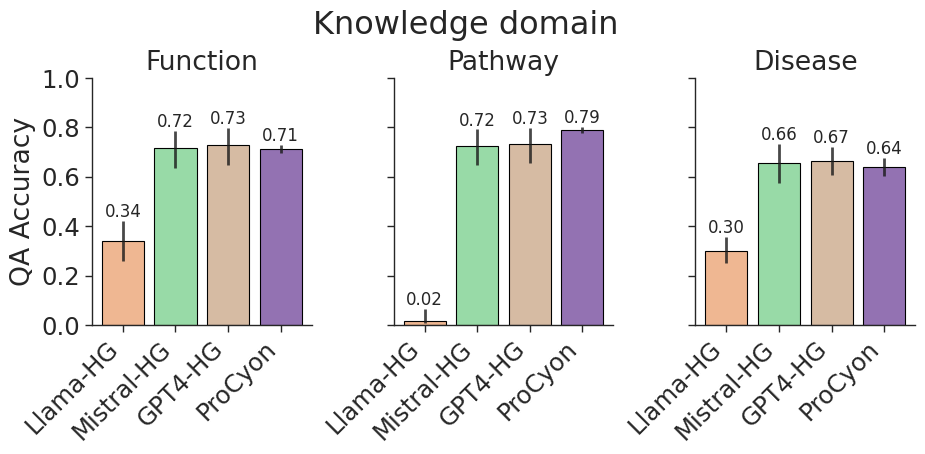

In [31]:
want_models = [
    llama_it_name,
    mistral_name,
    gpt_hgnc_name,
    model_name,
]
plot_data = (
    qa_metrics_by_kd
    .query("metric == 'Accuracy'")
    .loc[lambda x: x.model.isin(want_models)]
)

fg = sns.FacetGrid(
    data=plot_data,
    col="knowledge_domain",
    margin_titles=False,
    col_order=kd_order,
)
fg.figure.set_figwidth(10)
fg.figure.set_figheight(4)

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="val",
    order=want_models,
    edgecolor="black",
    hue="model",
    palette=llm_model_colors,
    errorbar=None,
)
fg.set_titles(template="{col_name}")

for ax in fg.axes[0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

fg.set_axis_labels(x_var="", y_var="QA Accuracy")
fg.figure.supxlabel("Knowledge domain",y=0.95, va="bottom", x=0.5)
fg.set(ylim=(0, 1))

for kd, ax in fg.axes_dict.items():

    rects = [x[0] for x in ax.containers]
    rects = sorted(rects, key=lambda x: x.get_x())


    x_coords = []
    y_coords = []
    yerr = []
    for rect, model in zip(rects, want_models):
        want_df = plot_data.query("knowledge_domain == @kd and model == @model")
        assert len(want_df) == 1
        lb = want_df.iloc[0].val_lb
        ub = want_df.iloc[0].val_ub

        xval = rect.get_center()[0]
        yval = rect.get_height()

        x_coords.append(xval)
        y_coords.append(yval)
        yerr.append(np.abs((lb - yval, ub - yval)))

        # Add text above the bar
        text_pos = max(0, ub)
        ax.text(
            x=xval,
            y=text_pos,
            s=f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    yerr = np.array(yerr).T
    ax.errorbar(
        x=x_coords,
        y=y_coords,
        yerr=yerr,
        fmt="none",
        c="k",
        alpha=0.8,
        elinewidth=2,
    )

### Phenotype generation

In [32]:
plot_data = (
    caption_plot_data
        .assign(metric="Bertscore F1")
        .rename(columns=lambda x: x.replace("bertscore_f1_max", "val"))
        [["model", "knowledge_domain", "metric", "val", "val_lb", "val_ub"]]
        .loc[lambda x: x.model.isin(want_models)]
)

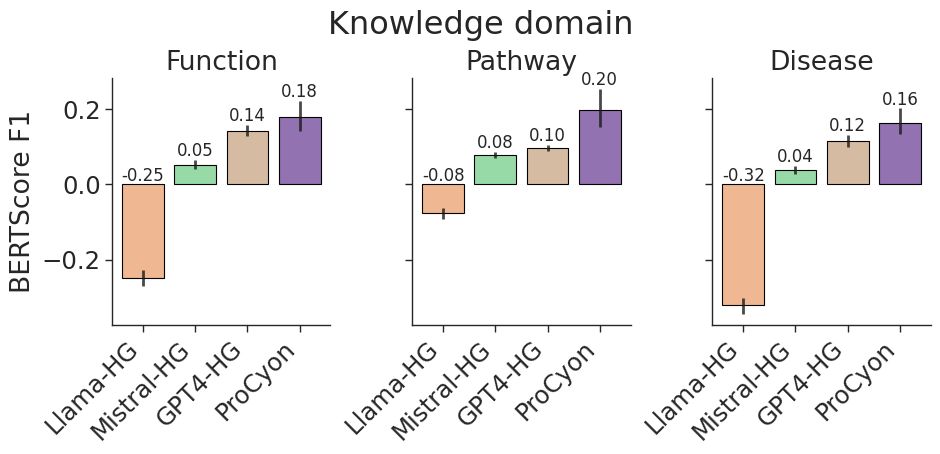

In [33]:
fg = sns.FacetGrid(
    data=plot_data,
    col="knowledge_domain",
    margin_titles=False,
    col_order=kd_order,
)
fg.figure.set_figwidth(10)
fg.figure.set_figheight(4)

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="val",
    order=want_models,
    edgecolor="black",
    hue="model",
    palette=llm_model_colors,
    errorbar=None,
)
fg.set_titles(template="{col_name}")

for ax in fg.axes[0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate labels 45 degrees
        label.set_ha("right")

fg.set_axis_labels(x_var="", y_var="BERTScore F1")
fg.figure.supxlabel("Knowledge domain",y=0.95, va="bottom", x=0.5)
#fg.set(ylim=(0, 1))

for kd, ax in fg.axes_dict.items():

    rects = [x[0] for x in ax.containers]
    rects = sorted(rects, key=lambda x: x.get_x())

    # rects = [x for x in ax.containers[0]]
    # rects = sorted(rects, key=lambda x: x.get_x())

    x_coords = []
    y_coords = []
    yerr = []
    for rect, model in zip(rects, want_models):
        want_df = plot_data.query("knowledge_domain == @kd and model == @model")
        assert len(want_df) == 1
        lb = want_df.iloc[0].val_lb
        ub = want_df.iloc[0].val_ub

        xval = rect.get_center()[0]
        yval = rect.get_height()

        x_coords.append(xval)
        y_coords.append(yval)
        yerr.append(np.abs((lb - yval, ub - yval)))

        # Add text above the bar
        text_pos = max(0, ub)
        ax.text(
            x=xval,
            y=text_pos,
            s=f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    yerr = np.array(yerr).T
    ax.errorbar(
        x=x_coords,
        y=y_coords,
        yerr=yerr,
        fmt="none",
        c="k",
        alpha=0.8,
        elinewidth=2,
    )

### Phenotype generation by protein encoding method

#### Split out knowledge domains

In [34]:
want_models = [
    model_name
] + gpt_model_names
plot_data = (
    caption_plot_data
    .rename(columns=lambda x: x.replace("bertscore_f1_max", "val"))
    [["model", "knowledge_domain", "val", "val_lb", "val_ub"]]
    .loc[lambda x: x.model.isin(want_models)]
)
model_colors = {name: llm_model_colors[name] for name in models}

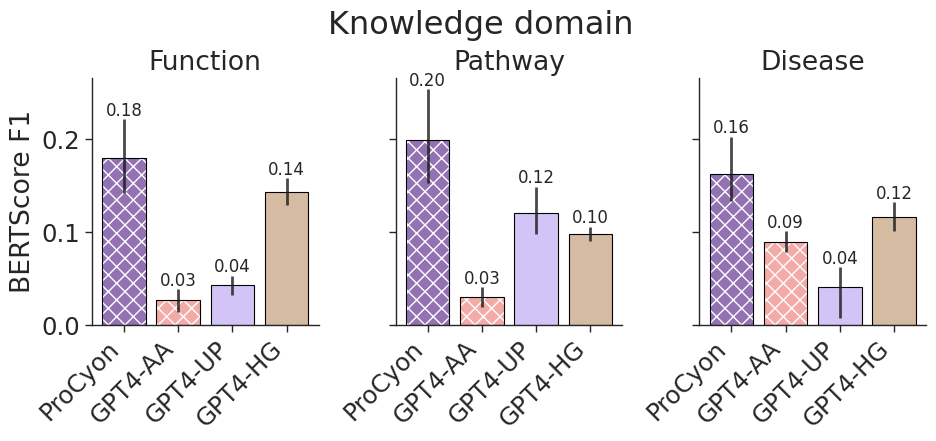

In [35]:
plt.rcParams.update({'hatch.color': 'white'})

fg = sns.FacetGrid(
    data=plot_data,
    col="knowledge_domain",
    margin_titles=False,
    col_order=kd_order,
)
fg.figure.set_figwidth(10)
fg.figure.set_figheight(4)

fg.map_dataframe(
    sns.barplot,
    x="model",
    y="val",
    order=want_models,
    edgecolor="black",
    hue="model",
    palette=llm_model_colors,
    errorbar=None,
)
fg.set_titles(template="{col_name}")

for ax in fg.axes[0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

fg.set_axis_labels(x_var="", y_var="BERTScore F1")
fg.figure.supxlabel("Knowledge domain",y=0.95, va="bottom", x=0.5)
#fg.set(ylim=(0, 1))

for kd, ax in fg.axes_dict.items():

    rects = [x[0] for x in ax.containers]
    rects = sorted(rects, key=lambda x: x.get_x())

    x_coords = []
    y_coords = []
    yerr = []
    for rect, model in zip(rects, want_models):
        if model == model_name or "AA" in model:
            rect.set(hatch="xx")
            rect._hatch_color = (1.0, 1.0, 1.0, 1.0)

        want_df = plot_data.query("knowledge_domain == @kd and model == @model")
        assert len(want_df) == 1
        lb = want_df.iloc[0].val_lb
        ub = want_df.iloc[0].val_ub

        xval = rect.get_center()[0]
        yval = rect.get_height()

        x_coords.append(xval)
        y_coords.append(yval)
        yerr.append(np.abs((lb - yval, ub - yval)))

        # Add text above the bar
        text_pos = max(0, ub)
        ax.text(
            x=xval,
            y=text_pos,
            s=f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    yerr = np.array(yerr).T
    ax.errorbar(
        x=x_coords,
        y=y_coords,
        yerr=yerr,
        fmt="none",
        c="k",
        alpha=0.8,
        elinewidth=2,
    )

#### Aggregated

In [36]:
from scipy.stats import bootstrap

def calc_error_bounds(vals):
    rng = np.random.default_rng(seed=42)

    res = bootstrap(
        (vals,),
        statistic=np.mean,
        confidence_level=0.95,
        n_resamples=9999,
        batch=10000,
        random_state=rng,
        paired=False,
    )
    return (res.confidence_interval.low,res.confidence_interval.high)

ProCyon 0.17985727026462528 0.20376848770514686
GPT4-AA 0.047066233057180176 0.05428692911651391
GPT4-UP 0.07977641600087361 0.08888927383660537
GPT4-HG 0.1219306271884709 0.13022559508277576


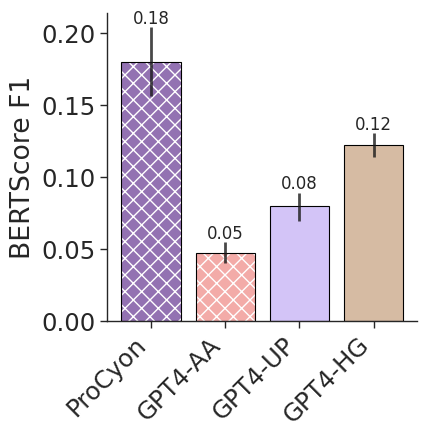

In [37]:
mertic = "bertscore_f1_max"
plot_data_for_encodes = (
    all_captions
    .reset_index(drop=True)
    .loc[lambda x: x.model.isin(want_models)]
)

plt.rcParams.update({'hatch.color': 'white'})
sns.set_theme(context="paper", style="ticks", font_scale=2,)

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    x="model",
    y=metric,
    order=want_models,
    edgecolor="black",
    hue="model",
    palette=llm_model_colors,
    errorbar=None,
    data=plot_data_for_encodes,
    ax=ax,
)

fg.set_titles(template="{col_name}")

for label in ax.get_xticklabels():
    label.set_rotation(45)  # Rotate labels 45 degrees
    label.set_ha("right")

ax.set_ylabel("BERTScore F1")
ax.set_xlabel("")


rects = [x[0] for x in ax.containers]
rects = sorted(rects, key=lambda x: x.get_x())

x_coords = []
y_coords = []
yerr = []
for rect, model in zip(rects, want_models):
    if model == model_name or "AA" in model:
        rect.set(hatch="xx")
        rect._hatch_color = (1.0, 1.0, 1.0, 1.0)

    want_df = plot_data_for_encodes.query("model == @model")
    lb, ub = calc_error_bounds(want_df[metric].values)

    xval = rect.get_center()[0]
    yval = rect.get_height()

    x_coords.append(xval)
    y_coords.append(yval)
    yerr.append(np.abs((lb - yval, ub - yval)))

    print(model, yval, ub)

    # Add text above the bar
    ax.text(
        x=xval,
        y=ub,
        s=f"{yval:.2f}",
        ha="center",
        va="bottom",
        fontsize=12,
    )

yerr = np.array(yerr).T
ax.errorbar(
    x=x_coords,
    y=y_coords,
    yerr=yerr,
    fmt="none",
    c="k",
    alpha=0.8,
    elinewidth=2,
)

sns.despine()

# LLM as a judge

In [38]:
def parse_row(row):
    found = re.findall("\[\[(\w)\]\]", row.response)
    if hasattr(row, "finish_reason") and row.finish_reason == "length":
        return "truncated"
    elif len(found) == 0:
        return "none"
    elif len(found) == 1:
        char = found[0]
        if char == "A":
            return row.prompt_a
        elif char == "B":
            return row.prompt_b
        elif char == "C":
            return "tie"
        else:
            print(f"bad char: {char}")
            return "none"
    else:
        print(f"bad output: {found}")
        return "none"


def check_file(df, fname):
    if len(df) % 2 != 0:
        df = df.drop_duplicates(["protein_id", "prompt_a", "prompt_b"])
        if len(df) % 2 != 0:
            raise ValueError(f"bad file: {fname}")
        else:
            print(f"duplicates in file: {fname}")
    return df

def parse_results_one(df):
    res = []
    assert (df.protein_id.value_counts() == 2).all()
    for i in range(0, len(df), 2):
        selection_a = parse_row(df.iloc[i])
        selection_b = parse_row(df.iloc[i+1])
        is_valid =  selection_a in ["txplm", "llm", "tie"]  and selection_b in ["txplm", "llm", "tie"]
        res.append({
            "protein_id": df.protein_id.iloc[i],
            "selection_a": selection_a,
            "selection_b": selection_b,
            "valid": is_valid,
            "agree": is_valid and (selection_a == selection_b),
        })
    return (
        pd.DataFrame(res)
        .assign(
            result=lambda x: np.where(~x.valid,
                                     "invalid",
                                     np.where(~x.agree,
                                             "disagree",
                                             x.selection_a)),
            has_tie=lambda x: (x.selection_a == "tie") | (x.selection_b == "tie"),
            tiebreak_result=lambda x: np.where((x.result == "disagree") & x.has_tie,
                                                np.where(x.selection_a == "tie",
                                                         x.selection_b,
                                                         x.selection_a),
                                                x.result),
         )
        .drop(columns=["has_tie"])
    )


def parse_results_flat(files_dict, load_func=pd.read_csv, break_ties=False):
    all_results = []
    for model_name, files in files_dict.items():
        for f in files:
            df = load_func(f)
            df = check_file(df, f)
            res = parse_results_one(df)
            all_results.append(res.assign(versus=model_name, dataset=f.split("/")[-1].split(".")[0]))
    all_results = pd.concat(all_results)

    return all_results


In [39]:
files = {
    gpt_aaseq_name: [
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_disgenet_all.judge_queries.aaseq.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_uniprot_all.judge_queries.aaseq.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/reruns/protein_reactome_all.judge_queries.aaseq.responses.csv',
    ],
    gpt_uniprot_name: [
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_uniprot_all.judge_queries.uniprot.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_disgenet_all.judge_queries.uniprot.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_reactome_all.judge_queries.uniprot.responses.csv',
    ],
    gpt_hgnc_name: [
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_disgenet_all.judge_queries.gene_name.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/protein_uniprot_all.judge_queries.gene_name.responses.csv',
        '/n/home08/rcalef/storage/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/claude_judge/reruns/protein_reactome_all.judge_queries.gene_name.responses.csv'
    ],
    mistral_name: [
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/caption_eval/llm_as_a_judge/outputs/protein_disgenet_all.judge_queries.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/caption_eval/llm_as_a_judge/outputs/protein_uniprot_all.judge_queries.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/mistral_large_comparison/caption_eval/llm_as_a_judge/outputs/protein_reactome_all.judge_queries.gene_name.responses.csv",
    ],
    llama_it_name: [
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_disgenet_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_uniprot_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_reactome_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv",
    ],
    llama_name: [
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_disgenet_all.llm_judge_prompts.llama_no_instruct.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_uniprot_all.llm_judge_prompts.llama_no_instruct.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_reactome_all.llm_judge_prompts.llama_no_instruct.gene_name.responses.csv",
    ],
    "pos_control": [
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/pos_control/reference_matched/outputs/protein_disgenet_all.judge_queries.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/pos_control/reference_matched/outputs/protein_uniprot_all.judge_queries.gene_name.responses.csv",
        "/n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/caption_eval/llm_judge_prompts/pos_control/reference_matched/outputs/protein_reactome_all.judge_queries.gene_name.responses.csv",
    ]
}

In [40]:
flat_results = parse_results_flat(files, load_func=lambda x: pd.read_csv(x).reset_index(), break_ties=True)

duplicates in file: /n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_uniprot_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv
duplicates in file: /n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_reactome_all.llm_judge_prompts.llama_instruct.gene_name.responses.csv
duplicates in file: /n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_disgenet_all.llm_judge_prompts.llama_no_instruct.gene_name.responses.csv
duplicates in file: /n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_uniprot_all.llm_judge_prompts.llama_no_instruct.gene_name.responses.csv
duplicates in file: /n/holystore01/LABS/mzitnik_lab/Lab/PLM/generated_data/gpt_eval/llama_comparison/caption_eval/llm_judge/outputs/protein_reactome_all.llm

In [41]:
plot_data = (
    flat_results
    .loc[lambda x: x.tiebreak_result.isin(["llm", "txplm"]) &  x.versus.isin(models)]
    .assign(
        model_class=lambda x: np.where(x.versus.str.contains("GPT4"),
                                       frontier_model,
                                       np.where(x.versus.str.contains("Mistral"),
                                                med_model,
                                                small_model)),
        result=lambda x: np.where(x.tiebreak_result == "llm", 1, 0),
        kd=lambda x: x.dataset.map(kd_map),
    )
    [["result", "versus", "model_class", "dataset", "kd"]]
)

In [42]:
def calc_error_bounds_llm_judge(vals):
    rng = np.random.default_rng(seed=42)

    vals = vals == 1
    res = bootstrap(
        (vals,),
        statistic=np.mean,
        confidence_level=0.95,
        n_resamples=9999,
        batch=10000,
        random_state=rng,
        paired=False,
    )
    return (res.confidence_interval.low,res.confidence_interval.high)

<Figure size 1000x1000 with 0 Axes>

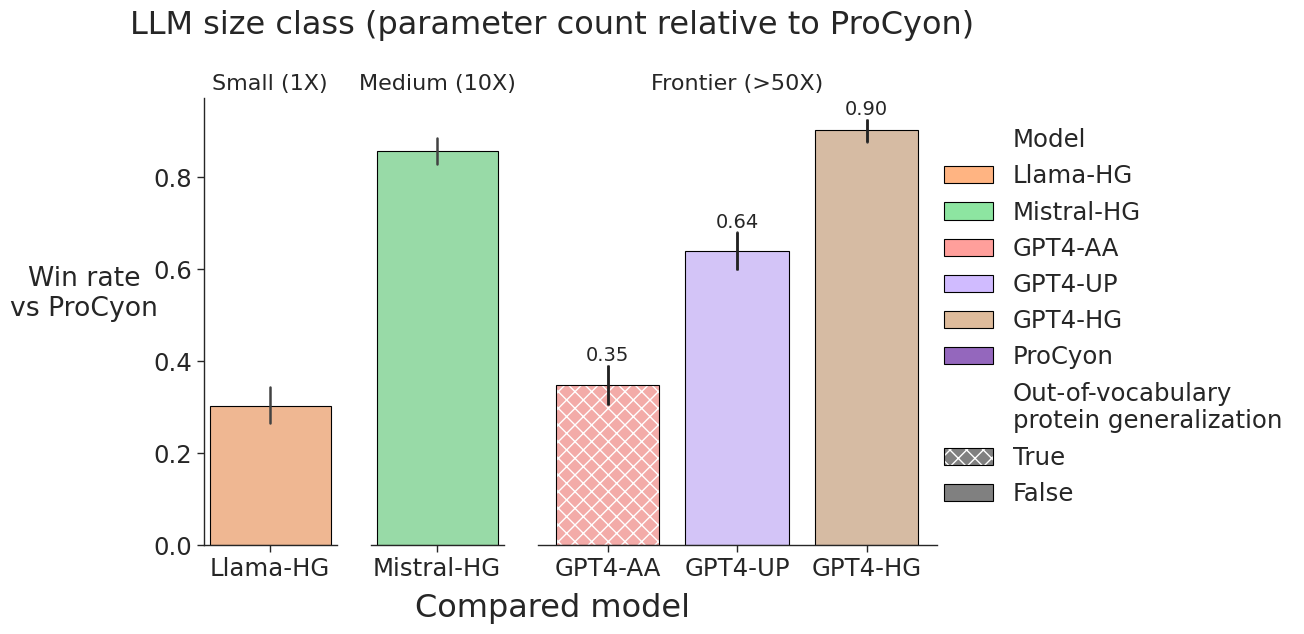

In [43]:
models = [
    llama_it_name,
    mistral_name
] + gpt_model_names

sns.set_theme(context="paper", style="ticks", font_scale=2)

plt.figure(figsize=(10, 10))

def estimate(vals):
    return (vals == 1).mean()


fg = sns.FacetGrid(
    col="model_class",
    col_order=model_classes,
    data=plot_data.loc[lambda x: x.versus.isin(models)],
    height=6,
    aspect=0.5,
    gridspec_kws={"width_ratios": [1/3, 1/3, 1]},
    sharex=False,
)

fg.map_dataframe(
    sns.barplot,
    x="versus",
    y="result",
    hue="versus",
    estimator=estimate,
    edgecolor="black",
    palette=llm_model_colors,
    data=plot_data,
)

sns.despine()
fg.set_xlabels("")
fg.set_ylabels(f"Win rate\nvs {model_name}", rotation="horizontal", ha="center", labelpad=50)
fg.despine()

for i, (model_class, ax) in enumerate(fg.axes_dict.items()):
    ax.set_title(model_class, fontsize=16)
    ax.set_xlabel("")
    if i != 0:
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
    if i == 2:
        want_rect = ax.patches[0]
        want_rect.set_hatch("x")


    class_models = plot_data.query("model_class == @model_class").versus.unique()
    order = [x for x in want_models if x in class_models]

    rects = [x[0] for x in ax.containers]
    rects = sorted(rects, key=lambda x: x.get_x())

    x_coords = []
    y_coords = []
    yerr = []
    for rect, model in zip(rects, order):
        if model == model_name or "AA" in model:
            rect.set(hatch="xx")
            rect._hatch_color = (1.0, 1.0, 1.0, 1.0)
        want_df = plot_data.query("versus == @model")
        lb, ub = calc_error_bounds_llm_judge(want_df.result.values)

        xval = rect.get_center()[0]
        yval = rect.get_height()

        x_coords.append(xval)
        y_coords.append(yval)
        yerr.append(np.abs((lb - yval, ub - yval)))

        # Add text above the bar
        ax.text(
            x=xval,
            y=ub,
            s=f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontsize=14,
        )

    yerr = np.array(yerr).T
    ax.errorbar(
        x=x_coords,
        y=y_coords,
        yerr=yerr,
        fmt="none",
        c="k",
        alpha=0.8,
        elinewidth=2,
    )

fg.figure.suptitle(f"LLM size class (parameter count relative to {model_name})", y=1, va="bottom", x=0.4)
fg.figure.supxlabel(f"Compared model", y=0.08, va="top", x=0.4)

legend_data = [("Model",  mpatches.Patch(facecolor="gray", visible=False))]
want_models = [
    llama_it_name,
    mistral_name,
    gpt_aaseq_name,
    gpt_uniprot_name,
    gpt_hgnc_name,
    model_name,
]
legend_data += [(name, mpatches.Patch(facecolor=llm_model_colors[name], edgecolor="black")) for name in want_models]

true_patch = mpatches.Patch(facecolor="gray", label="True", edgecolor="black")
true_patch._hatch_color = (1.0, 1.0, 1.0, 1.0)
false_patch = mpatches.Patch(facecolor="gray", label="False", edgecolor="black")
true_patch.set_hatch("xx")
legend_data += [
    ("Out-of-vocabulary\nprotein generalization", mpatches.Patch(facecolor="gray", visible=False)),
    ("True", true_patch),
    ("False", false_patch),
]

fg._legend_data = {x:y for (x, y) in legend_data}

fg.add_legend()
plt.savefig(os.path.expanduser("~/tmp/llm_judge_win_rates_for_paper.svg"))

Text(0.5, 1.0, 'model_class = Small (1X)')
Text(0.5, 1.0, 'model_class = Medium (10X)')
Text(0.5, 1.0, 'model_class = Frontier (>50X)')


<Figure size 1000x1000 with 0 Axes>

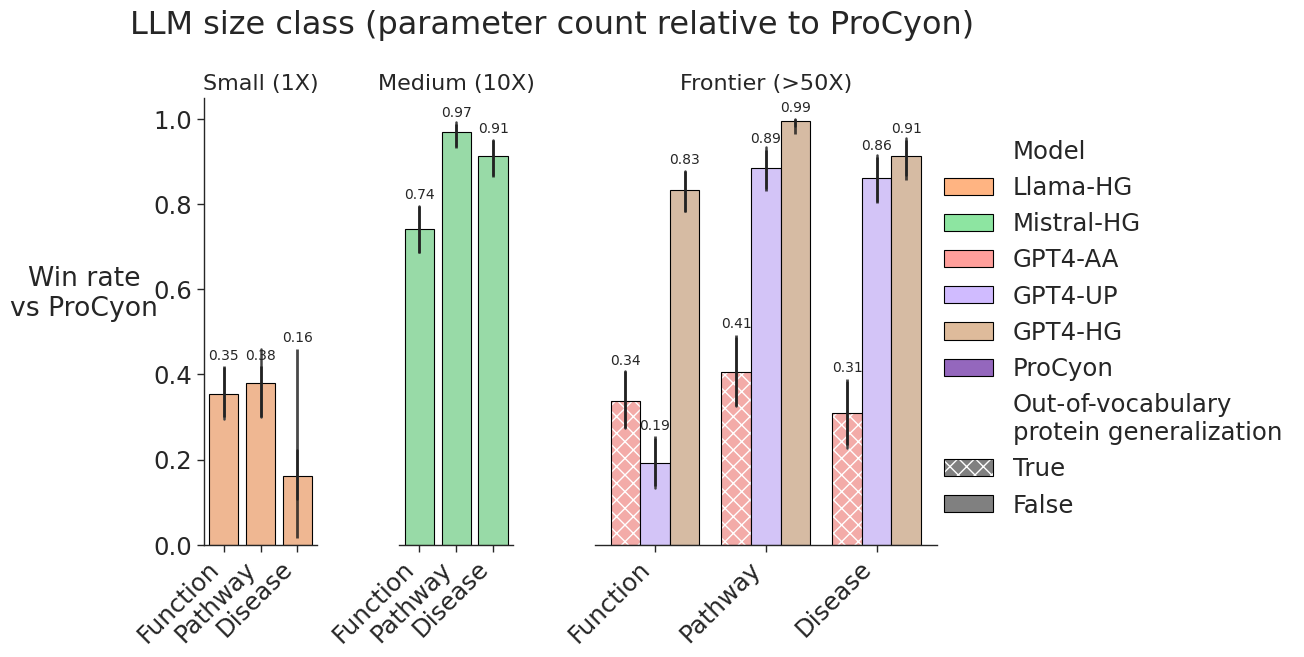

In [44]:
from itertools import cycle

models = [
    llama_it_name,
    mistral_name
] + gpt_model_names

#sns.set_theme(context="poster", style="ticks", font_scale=0.8)
sns.set_theme(context="paper", style="ticks", font_scale=2)

plt.figure(figsize=(10, 10))

def estimate(vals):
    return (vals == 1).mean()


fg = sns.FacetGrid(
    col="model_class",
    col_order=model_classes,
    data=plot_data.loc[lambda x: x.versus.isin(models)],
    height=6,
    aspect=0.5,
    gridspec_kws={"width_ratios": [1/3, 1/3, 1]},
    sharex=False,
)

fg.map_dataframe(
    sns.barplot,
    x="kd",
    y="result",
    hue="versus",
    estimator=estimate,
    edgecolor="black",
    palette=llm_model_colors,
    order=kd_order,
    data=plot_data,
)

sns.despine()
fg.set_xlabels("")
fg.set_ylabels(f"Win rate\nvs {model_name}", rotation="horizontal", ha="center", labelpad=50)
fg.despine()

for i, (model_class, ax) in enumerate(fg.axes_dict.items()):
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate labels 45 degrees
        label.set_ha("right")

    print(ax.title)
    ax.set_title(model_class, fontsize=16)
    ax.set_xlabel("")
    if i != 0:
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
    if i == 2:
        want_rect = ax.patches[0]
        want_rect.set_hatch("x")


    class_models = plot_data.query("model_class == @model_class").versus.unique()
    order = [x for x in want_models if x in class_models]

    rects = [x for kd_group in ax.containers for x in kd_group]
    rects = sorted(rects, key=lambda x: x.get_x())

    x_coords = []
    y_coords = []
    yerr = []
    for i, (rect, model) in enumerate(zip(rects, cycle(order))):
        kd = kd_order[i // len(class_models)]

        if model == model_name or "AA" in model:
            rect.set(hatch="xx")
            rect._hatch_color = (1.0, 1.0, 1.0, 1.0)
        want_df = plot_data.query("versus == @model and kd == @kd")
        lb, ub = calc_error_bounds_llm_judge(want_df.result.values)

        xval = rect.get_center()[0]
        yval = rect.get_height()

        x_coords.append(xval)
        y_coords.append(yval)
        yerr.append(np.abs((lb - yval, ub - yval)))

        # Add text above the bar
        ax.text(
            x=xval,
            y=ub+0.01,
            s=f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    yerr = np.array(yerr).T
    ax.errorbar(
        x=x_coords,
        y=y_coords,
        yerr=yerr,
        fmt="none",
        c="k",
        alpha=0.8,
        elinewidth=2,
    )

fg.figure.suptitle(f"LLM size class (parameter count relative to {model_name})", y=1, va="bottom", x=0.4)

legend_data = [("Model",  mpatches.Patch(facecolor="gray", visible=False))]
want_models = [
    llama_it_name,
    mistral_name,
    gpt_aaseq_name,
    gpt_uniprot_name,
    gpt_hgnc_name,
    model_name,
]
legend_data += [(name, mpatches.Patch(facecolor=llm_model_colors[name], edgecolor="black")) for name in want_models]

true_patch = mpatches.Patch(facecolor="gray", label="True", edgecolor="black")
true_patch._hatch_color = (1.0, 1.0, 1.0, 1.0)
false_patch = mpatches.Patch(facecolor="gray", label="False", edgecolor="black")
true_patch.set_hatch("xx")
legend_data += [
    ("Out-of-vocabulary\nprotein generalization", mpatches.Patch(facecolor="gray", visible=False)),
    ("True", true_patch),
    ("False", false_patch),
]

fg._legend_data = {x:y for (x, y) in legend_data}

fg.add_legend()
# plt.savefig(os.path.expanduser("~/tmp/llm_judge_win_rates_for_paper.svg"))

# Extended data

## QA filtering performance

In [45]:
def cumulative_bin(df, col="yes_binned", min_keep=0):
    duped = []
    for thresh in df[col].unique():
        for _, sub_df in df.groupby("seq_id"):
            sub_df = sub_df.sort_values(col, ascending=False)
            above_thresh = sub_df[col] >= thresh
            if above_thresh.sum() < min_keep:
                keep = sub_df.head(n=min_keep)
            else:
                keep = sub_df.loc[above_thresh]

            if len(keep) != 0:
                keep[col] = thresh
                duped.append(keep)
    return pd.concat(duped)

def prep_dataset(
    path: str,
    metric: str = "bertscore_f1",
) -> pd.DataFrame:
    scored_captions = (
        get_scored_captions(path)
        .groupby(["seq_id", "generated_caption"])
        [["yes", metric]]
        .max()
        .reset_index()
        .drop(columns="generated_caption")
        [["seq_id", metric, "yes"]]
        .assign(
            yes_binned=lambda x: pd.cut(x.yes, bins=np.linspace(0, 1, 11)),
        )
    )
    return scored_captions

In [48]:
all_scored_captions = []
for path in dataset_paths:
    scored = prep_dataset(path)
    all_scored_captions.append(
        cumulative_bin(scored, col="yes_binned", min_keep=1).assign(dataset=path)
    )

all_scored_captions = (
    pd.concat(all_scored_captions)
    .assign(
        dataset=lambda x: x.dataset.str.replace("_all", "", n=1),
        knowledge_domain=lambda x: x.dataset.map(kd_map),
    )
)
all_scored_captions.head()

/tmp/ipykernel_3826187/4187173194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep[col] = thresh
/tmp/ipykernel_3826187/4187173194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep[col] = thresh
/tmp/ipykernel_3826187/4187173194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,seq_id,bertscore_f1,yes,yes_binned,dataset,knowledge_domain
1,58,0.978447,0.873315,"(0.3, 0.4]",protein_reactome_all,Pathway
3,58,0.102032,0.865938,"(0.3, 0.4]",protein_reactome_all,Pathway
2,58,0.058170,0.739556,"(0.3, 0.4]",protein_reactome_all,Pathway
0,58,-0.012195,0.311351,"(0.3, 0.4]",protein_reactome_all,Pathway
6,59,0.431476,0.910791,"(0.3, 0.4]",protein_reactome_all,Pathway


/tmp/ipykernel_3826187/3236875129.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_3826187/3236875129.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_3826187/3236875129.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


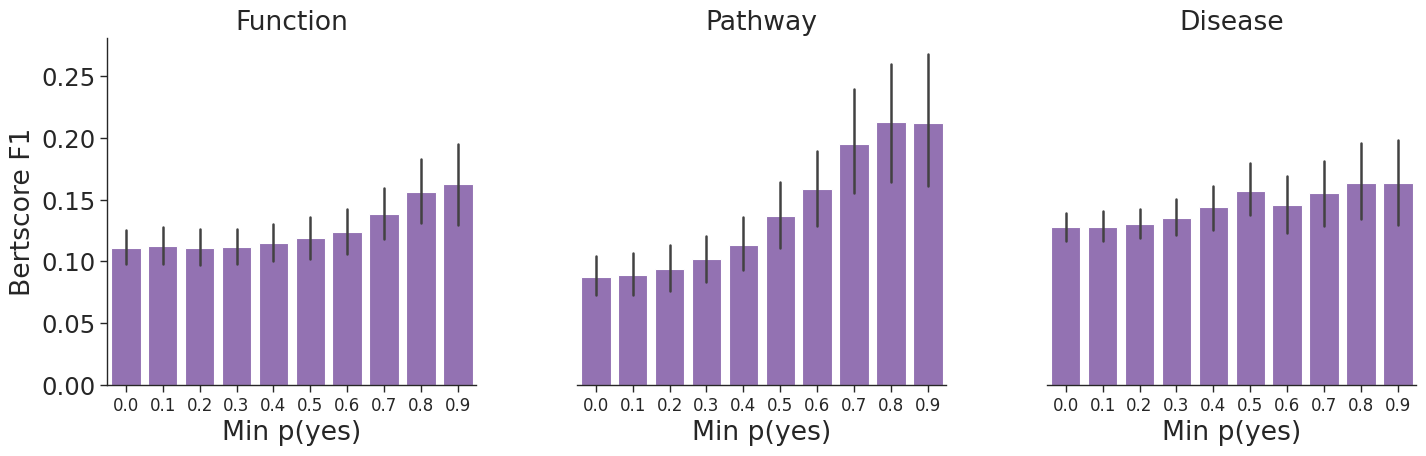

In [52]:
kd_order = ["Function", "Pathway", "Disease"]
metric = "bertscore_f1"
order = all_scored_captions.yes_binned.drop_duplicates().sort_values().astype(str).to_list()

plot_data = (
    all_scored_captions
    .astype({"yes_binned": str})
)

sns.set_theme(context="paper", style="ticks", font_scale=2,)

fg = sns.FacetGrid(
    col="knowledge_domain",
    col_order=kd_order,
    data=plot_data,
    height=5,
    aspect=1,
)
fg.map_dataframe(sns.barplot, x="yes_binned", y=metric, order=order, color=llm_model_colors[model_name])

sns.despine()
fg.despine()


for row in fg.axes:
    for i, ax in enumerate(row):
        curr_title = ax.title.get_text()
        kd = curr_title.replace("knowledge_domain = ", "")
        ax.set_title(kd)
        ax.set_xlabel("Min p(yes)")

        labels = ax.get_xticklabels()
        labels = [l.get_text().split(",")[0].strip("(") for l in labels]
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if i != 0:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            ax.set_ylabel("Bertscore F1")

#plt.savefig(os.path.expanduser("~/tmp/qa_filter_bertscore.extended_data.svg"))